In [166]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import random
from tqdm import tqdm
import shutil
import time
import copy
from glob import glob

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix
import albumentations as A


In [167]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:1


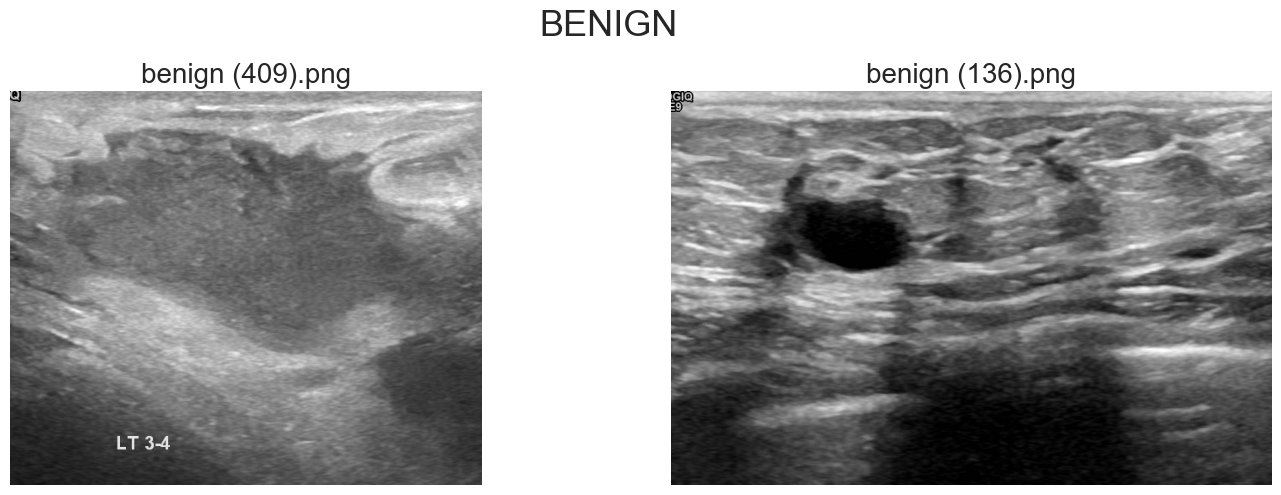

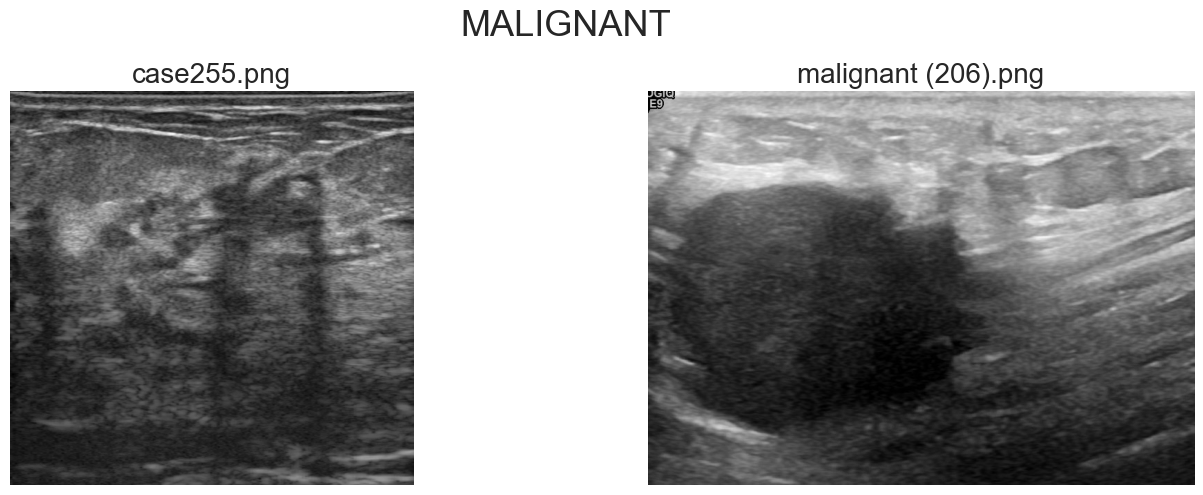

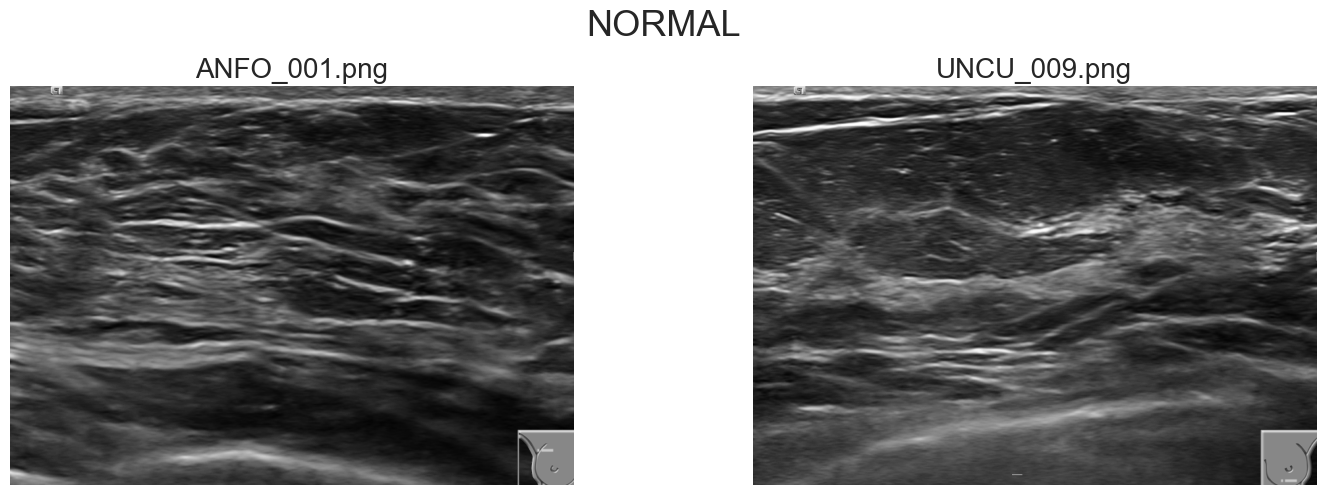

In [168]:
data_dir = r'E:\Eden\OnlineDataset\Joined_Dataset\full_dataset'
class_names = ['benign', 'malignant', 'normal']

for category in class_names:
    path = os.path.join(data_dir, category)
    fig, axes = plt.subplots(1,2, figsize=(15, 5))
    for i in range(2):
        img = np.random.choice(os.listdir(path))
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img_array, cmap='gray')
        axes[i].set_title(img, fontsize=20)
        axes[i].axis('off')

    plt.suptitle(category.upper(), fontsize=26)
    plt.tight_layout()

    plt.show()


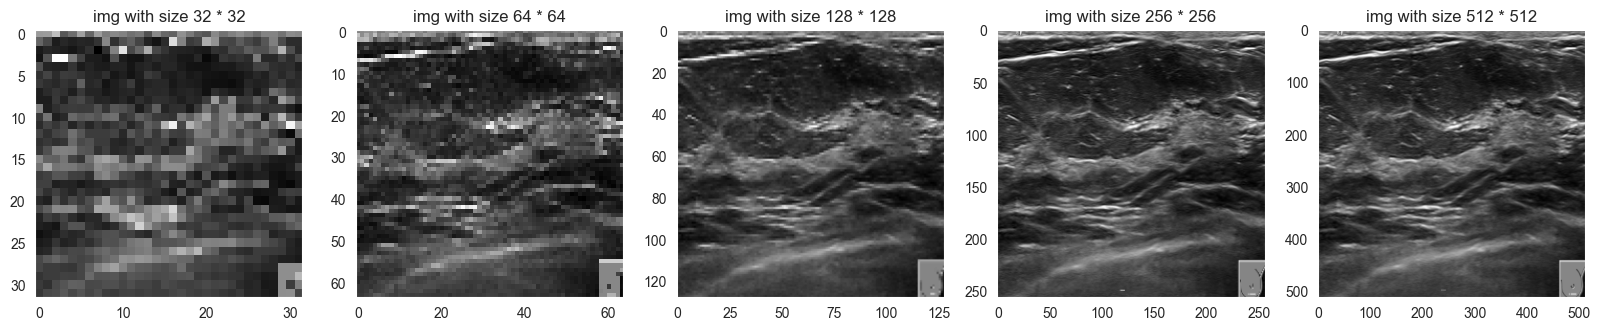

In [169]:
img_sz = 2**np.array([5, 6, 7, 8, 9])
plt.figure(figsize=(20, 5))

for i, sz in enumerate(img_sz):
    new_array = cv2.resize(img_array, (sz, sz))
    plt.subplot(1, len(img_sz), i+1)
    plt.imshow(new_array, cmap='gray')
    plt.title(f"img with size {sz} * {sz}")
    plt.grid()

plt.show()


In [170]:
#size (256*256) is okay
img_sz=256


In [171]:
# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            labels.append(label)
            file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})


In [172]:
# Calculate all counts at once
label_counts = data['Label'].value_counts()

# Print the results
print(f"{label_counts.get('benign', 0)} Benign Images")
print(f"{label_counts.get('malignant', 0)} Malignant Images")
print(f"{label_counts.get('normal', 0)} Normal Images")

652 Benign Images
381 Malignant Images
516 Normal Images


In [173]:
data_dir_UCLM = r'E:\Eden\OnlineDataset\BUS-UCLM Breast ultrasound lesion segmentation dataset\BUS-UCLM Breast ultrasound lesion segmentation dataset\BUS-UCLM\images'
data_dir_USG = r'E:\Eden\OnlineDataset\BrEaST-Lesions_USG-images_and_masks'
data_dir_BUSI = r'E:\Eden\OnlineDataset\archive\Images'

In [174]:
# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir_UCLM):
    label_dir = os.path.join(data_dir_UCLM, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            labels.append(label)
            file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data_UCLM = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

In [175]:
# Calculate all counts at once
label_counts = data_UCLM['Label'].value_counts()

# Print the results
print(f"{label_counts.get('benign', 0)} UCLM Benign Images")
print(f"{label_counts.get('malignant', 0)} UCLM Malignant Images")
print(f"{label_counts.get('normal', 0)} UCLM Normal Images")

174 UCLM Benign Images
90 UCLM Malignant Images
419 UCLM Normal Images


In [176]:
# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir_USG):
    label_dir = os.path.join(data_dir_USG, label, 'images')
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            labels.append(label)
            file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data_USG = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

In [177]:
# Calculate all counts at once
label_counts = data_USG['Label'].value_counts()

# Print the results
print(f"{label_counts.get('benign', 0)} USG Benign Images")
print(f"{label_counts.get('malignant', 0)} USG Malignant Images")
print(f"{label_counts.get('normal', 0)} USG Normal Images")

154 USG Benign Images
98 USG Malignant Images
4 USG Normal Images


In [178]:
# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir_BUSI):
    label_dir = os.path.join(data_dir_BUSI, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            labels.append(label)
            file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data_BUSI = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

In [179]:
# Calculate all counts at once
label_counts = data_BUSI['Label'].value_counts()

# Print the results
print(f"{label_counts.get('benign', 0)} Benign Images")
print(f"{label_counts.get('malignant', 0)} Malignant Images")
print(f"{label_counts.get('normal', 0)} Normal Images")

324 Benign Images
193 Malignant Images
93 Normal Images


In [180]:
OUTPUT_DIR = r'E:\Eden\OnlineDataset\Joined_Dataset\not_augmented_train'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

    DATA_DIR = data_dir

    CLASSES = ["normal", "benign", "malignant"]

    # ------------------------
    # Target final counts
    # ------------------------
    TARGET_COUNTS = {
        "normal": 419,
        "benign": 498,
        "malignant": 283
    }

    # ------------------------
    # Augmentation pipeline
    # ------------------------
    aug = A.Compose([
        A.HorizontalFlip(p=0.8),
        # A.RandomRotate90(p=0.5),
        A.Rotate(limit=20, crop_border=True, p=1),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussNoise(std_range=[0.02, 0.08], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, shift_limit_x=0.1, shift_limit_y=0.1, rotate_method='largest_box', rotate_limit=0, p=0.5),
        A.Affine(shear=15, translate_percent=0.05, rotate=0, p=0.5),
        A.Perspective(scale=(0.15, 0.15),p=0.5),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),

    ])

    def load_paths(folder):
        return glob(os.path.join(folder, "*"))

    def save_aug_image(img_array, out_path):
        Image.fromarray(img_array).save(out_path)

    def main():
        os.makedirs(OUTPUT_DIR, exist_ok=True)

        for cls in CLASSES:
            print(f"\nProcessing class: {cls}")
            in_dir = os.path.join(DATA_DIR, cls)
            out_dir = os.path.join(OUTPUT_DIR, cls)
            os.makedirs(out_dir, exist_ok=True)

            files = load_paths(in_dir)
            current_count = len(files)
            target_count = TARGET_COUNTS[cls]
            needed = target_count - current_count

            print(f"Current count: {current_count}")
            print(f"Target count:  {target_count}")
            print(f"To generate:   {needed}")

            # Copy all originals
            for f in files:
                Image.open(f).save(os.path.join(out_dir, os.path.basename(f)))

            if needed <= 0:
                print("No augmentation needed.")
                continue

            # Augment until reaching target count
            for i in tqdm(range(needed)):
                src = random.choice(files)
                img = np.array(Image.open(src))
                augmented = aug(image=img)["image"]
                out_name = f"aug_{i}_{os.path.basename(src)}"
                save_aug_image(augmented, os.path.join(out_dir, out_name))

        print("\nDone. Dataset balanced successfully.")

    if __name__ == "__main__":
        main()

In [181]:
# # Create a list to store file paths and labels
# file_paths = []
# labels = []
#
# # Loop through the subdirectories (benign, malignant, normal)
# for label in os.listdir(OUTPUT_DIR):
#     label_dir = os.path.join(OUTPUT_DIR, label)
#     if os.path.isdir(label_dir):
#         for image_file in os.listdir(label_dir):
#             image_path = os.path.join(label_dir, image_file)
#             labels.append(label)
#             file_paths.append(image_path)
#
# # Create a DataFrame to store the file paths and labels
# data_augmented = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

In [182]:
# # Create a list to store file paths and labels FOR TEST
# file_paths = []
# labels = []
# OUTPUT_DIR_TEST = r"E:\Eden\OnlineDataset\Joined_Dataset\test"
# # Loop through the subdirectories (benign, malignant, normal)
# for label in os.listdir(OUTPUT_DIR_TEST):
#     label_dir = os.path.join(OUTPUT_DIR_TEST, label)
#     if os.path.isdir(label_dir):
#         for image_file in os.listdir(label_dir):
#             image_path = os.path.join(label_dir, image_file)
#             labels.append(label)
#             file_paths.append(image_path)
#
# # Create a DataFrame to store the file paths and labels
# test_data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

In [183]:
# Calculate all counts at once
label_counts = data['Label'].value_counts()

# Print the results
print(f"{label_counts.get('benign', 0)} Benign Images")
print(f"{label_counts.get('malignant', 0)} Malignant Images")
print(f"{label_counts.get('normal', 0)} Normal Images")

652 Benign Images
381 Malignant Images
516 Normal Images


In [184]:
# # Calculate all counts at once FOR TEST
# label_counts = test_data['Label'].value_counts()
#
# # Print the results
# print(f"{label_counts.get('benign', 0)} Test Benign Images")
# print(f"{label_counts.get('malignant', 0)} Test Malignant Images")
# print(f"{label_counts.get('normal', 0)} Test Normal Images")

In [185]:
RANDOM_SEED = 42

In [186]:
train_data_UCLM, val_data_UCLM = train_test_split(data_UCLM, test_size=0.15, stratify=data_UCLM['Label'], random_state=RANDOM_SEED)
train_data_UCLM, test_data_UCLM = train_test_split(train_data_UCLM, test_size=0.2, stratify=train_data_UCLM['Label'], random_state=RANDOM_SEED)

In [187]:
train_data_USG, val_data_USG = train_test_split(data_USG, test_size=0.15, stratify=data_USG['Label'], random_state=RANDOM_SEED)
train_data_USG, test_data_USG = train_test_split(train_data_USG, test_size=0.2, stratify=train_data_USG['Label'], random_state=RANDOM_SEED)

In [188]:
train_data_BUSI, val_data_BUSI = train_test_split(data_BUSI, test_size=0.15, stratify=data_BUSI['Label'], random_state=RANDOM_SEED)
train_data_BUSI, test_data_BUSI = train_test_split(train_data_BUSI, test_size=0.2, stratify=train_data_BUSI['Label'], random_state=RANDOM_SEED)

In [189]:
train_data = pd.concat([train_data_UCLM, train_data_USG, train_data_BUSI], ignore_index=True)
val_data = pd.concat([val_data_UCLM, val_data_USG, val_data_BUSI], ignore_index=True)
test_data = pd.concat([test_data_UCLM, test_data_BUSI, test_data_BUSI], ignore_index=True)

In [190]:
# train_data, val_data = train_test_split(data, test_size=0.15, stratify=data['Label'], random_state=150)
# train_data, test_data = train_test_split(train_data, test_size=0.2, stratify=train_data['Label'], random_state=150)

In [191]:
# Split the dataset into train, validation, and test sets
# train_data, val_data = train_test_split(data_augmented, test_size=0.2, stratify=data_augmented['Label'], random_state=42)
# temp_data, test_data = train_test_split(data_test, test_size=1, stratify=train_data['Label'], random_state=159)

split_data_path = r'E:\Eden\OnlineDataset\Joined_Dataset\Try7_full_dataset_stratify'
# Define the paths for the train, validation, and test directories
train_dir = os.path.join(split_data_path, 'train')
if not os.path.exists(train_dir):
    os.makedirs(train_dir, exist_ok=True)
    for label in set(train_data['Label']):
        os.makedirs(os.path.join(train_dir, label), exist_ok=True)
        print('train', label)
    # Copy the images to the corresponding directories
    time.sleep(2)
    for _, row in train_data.iterrows():
        image_path = row['Image_Path']
        label = row['Label']
        shutil.copy(image_path, os.path.join(train_dir, label))

val_dir = os.path.join(split_data_path,'validation')
if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)
    for label in set(val_data['Label']):
        os.makedirs(os.path.join(val_dir, label), exist_ok=True)
        print('val', label)

    time.sleep(2)
    for _, row in val_data.iterrows():
        image_path = row['Image_Path']
        label = row['Label']
        shutil.copy(image_path, os.path.join(val_dir, label))

test_dir = os.path.join(split_data_path,'test')
if not os.path.exists(test_dir):
    os.makedirs(test_dir, exist_ok=True)
    for label in set(test_data['Label']):
        os.makedirs(os.path.join(test_dir, label), exist_ok=True)
        print('test', label)
    time.sleep(2)
    for _, row in test_data.iterrows():
        image_path = row['Image_Path']
        label = row['Label']
        shutil.copy(image_path, os.path.join(test_dir, label))

In [192]:
# Train
# List the subdirectories (benign, malignant, normal)
subdirectories = class_names.copy()

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
   # print("Train folder counts including masks:")
    print(f"Train {category}: {count}")

# Val
# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(val_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("Validation folder counts including masks:")
    print(f"Validation {category}: {count}")

# Test
# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("test folder counts including masks:")
    print(f"test {category}: {count}")


Train benign: 443
Train malignant: 258
Train normal: 350
Validation benign: 98
Validation malignant: 58
Validation normal: 78
test benign: 85
test malignant: 48
test normal: 87


In [193]:
# # Initialize sums
# psum = np.zeros(3)
# psum_sq = np.zeros(3)
# count = 0
#
# for path in data['Image_Path']:
#     img = np.array(Image.open(path).convert('RGB')) / 255.0  # Normalize to [0,1]
#     psum += img.sum(axis=(0, 1))
#     psum_sq += (img ** 2).sum(axis=(0, 1))
#     count += img.shape[0] * img.shape[1]
#
# mean = psum / count
# var = (psum_sq / count) - (mean ** 2)
# std = np.sqrt(var)
#
# print("Mean:", mean)
# print("Std:", std)

In [194]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
img_sz = 224
# # Define the minority classes in your dataset
# minority_classes = ['malignant', 'benign']
#
# # Define custom data transformations for minority classes
# minority_class_transforms = transforms.Compose([
#     v2.RandomHorizontalFlip(p=1.0),
#     v2.RandomRotation(22.5, expand=False, center=None),
#     v2.RandomPerspective(distortion_scale=0.25, p=1.0),
#     v2.RandomAffine(degrees=(0, 15), translate=(0.01, 0.05))
#     # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
# ])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_sz,img_sz)),
        v2.RandomHorizontalFlip(p=0.5),
        # v2.RandomVerticalFlip(p=0.3),
        v2.RandomRotation(degrees=10),
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1
        ),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1,1.0)),  # Mimics natural speckle smoothness

        # v2.RandomPerspective(distortion_scale=0.25, p=0.5),
        # v2.RandomAffine(degrees=(0, 15), translate=(0.01, 0.05)),
        # Apply custom augmentations to minority classes
        # transforms.RandomApply([minority_class_transforms], p=0.65) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'validation': transforms.Compose([
        transforms.Resize((img_sz,img_sz)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_sz,img_sz)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [195]:
# Create datasets for train, validation, and test
image_datasets = {
    x: ImageFolder(
        root=os.path.join(split_data_path, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

# def get_class_weights(dataset):
#     """Calculate weights for each sample to balance classes"""
#     # Get all targets (labels) from the dataset
#     targets = np.array([sample[1] for sample in dataset])
#
#     # Count samples per class
#     class_counts = np.bincount(targets)
#
#     # Calculate weight for each class (inverse frequency)
#     class_weights = 1.0 / class_counts
#
#     # Assign weight to each sample based on its class
#     sample_weights = class_weights[targets]
#
#     return sample_weights, class_counts
#
# # Calculate weights for training set only
# train_sample_weights, train_class_counts = get_class_weights(image_datasets['train'])
#
# print("\n" + "="*60)
# print("CLASS DISTRIBUTION IN TRAINING SET:")
# print("="*60)
# for idx, class_name in enumerate(image_datasets['train'].classes):
#     print(f"{class_name}: {train_class_counts[idx]} samples")
#
# print("\n" + "="*60)
# print("CLASS WEIGHTS (inverse frequency):")
# print("="*60)
# class_weights_unique = 1.0 / train_class_counts
# for idx, class_name in enumerate(image_datasets['train'].classes):
#     print(f"{class_name}: {class_weights_unique[idx]:.4f}")
# print("="*60 + "\n")

# # Create WeightedRandomSampler for training set
# train_sampler = WeightedRandomSampler(
#     weights=train_sample_weights,
#     num_samples=len(train_sample_weights),
#     replacement=True  # Allow sampling with replacement to oversample minority classes
# )


# Specify batch size for dataloaders
batch_size = 16  # You can adjust this based on your hardware and preferences

# # Create dataloaders for train, validation, and test
# dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
#                for x in ['train', 'validation', 'test']}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=batch_size,
        # sampler=train_sampler,  # ← Use sampler instead of shuffle
        shuffle=True,
        # num_workers=2  # Set to 0 if you have issues with multiprocessing
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=batch_size,
        shuffle=False  # No shuffling needed for validation
    ),
    'test': DataLoader(
        image_datasets['test'],
        batch_size=batch_size,
        shuffle=False  # No shuffling needed for test
    )
}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# Get class labels
class_names = image_datasets['train'].classes

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

Dataset Sizes: {'train': 1051, 'validation': 234, 'test': 220}
Class Labels: ['benign', 'malignant', 'normal']


In [196]:
# def verify_oversampling(dataloader, class_names, num_batches=10):
#     """Check class distribution in sampled batches"""
#     class_counts = {i: 0 for i in range(len(class_names))}
#
#     for i, (inputs, labels) in enumerate(dataloader):
#         if i >= num_batches:
#             break
#         for label in labels:
#             class_counts[label.item()] += 1
#
#     print("\n" + "="*60)
#     print(f"CLASS DISTRIBUTION IN FIRST {num_batches} BATCHES:")
#     print("="*60)
#     for class_idx, count in class_counts.items():
#         print(f"{class_names[class_idx]}: {count} samples")
#     print("="*60 + "\n")
#
# # Uncomment to verify oversampling is working:
# verify_oversampling(dataloaders['train'], class_names, num_batches=20)

In [197]:
# Define the training function with early stopping and additional features
def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')  # Initialize best_loss with a large value
    consecutive_epochs_without_improvement = 0

    # Lists to store training and validation losses
    train_losses, train_losses_running, train_acc = [], [], []
    val_losses, val_losses_running, val_acc = [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Append training loss here
                if phase == 'train':
                    train_losses_running.append(loss.item())  # Append training loss
                else:
                    val_losses_running.append(loss.item())  # Append validation loss

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).cpu()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Early stopping: Check if validation loss improved
            if phase == 'validation':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1

                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            else:
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

        # Check if early stopping criteria are met
        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Calculate classification report and confusion matrix for validation data
    y_true = []
    y_pred = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate classification report
    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    # Plot the confusion matrix with label names
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [198]:
# from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
#
# weights = EfficientNet_V2_S_Weights.DEFAULT
# model = efficientnet_v2_s(weights=weights)
#
# # Make all layers trainable
# for param in model.parameters():
#     param.requires_grad = True
#
# # Replace classifier head
# in_features = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(in_features, len(class_names))
#
# model = model.to(DEVICE)

########################
# from torchvision.models import vit_b_16, ViT_B_16_Weights
#
# weights = ViT_B_16_Weights.DEFAULT
# model = vit_b_16(weights=weights)
#
# for param in model.parameters():
#     param.requires_grad = True
#
# in_features = model.heads.head.in_features
# model.heads.head = nn.Linear(in_features, len(class_names))
#
# model = model.to(DEVICE)

#######################
from torchvision.models import swin_t, Swin_T_Weights

weights = Swin_T_Weights.DEFAULT
model = swin_t(weights=weights)

for param in model.parameters():
    param.requires_grad = True

# in_features = model.head.in_features
# model.head = nn.Linear(in_features, len(class_names))
in_features=model.head.in_features
model.head=nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features,len(class_names))
)

model = model.to(DEVICE)


In [199]:
#Define optimzation algorithm
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# # Decay LR by a factor of 0.1 every 7 epochs
# Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.2,
#     patience=5,
#     verbose=True
# )
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

Epoch 0/49
----------
train Loss: 0.9460 Acc: 0.5519
validation Loss: 0.6147 Acc: 0.7393

Epoch 1/49
----------
train Loss: 0.6581 Acc: 0.7193
validation Loss: 0.4742 Acc: 0.8248

Epoch 2/49
----------
train Loss: 0.5448 Acc: 0.7755
validation Loss: 0.4761 Acc: 0.7949

Epoch 3/49
----------
train Loss: 0.4732 Acc: 0.8059
validation Loss: 0.4803 Acc: 0.8077

Epoch 4/49
----------
train Loss: 0.4272 Acc: 0.8325
validation Loss: 0.4048 Acc: 0.8419

Epoch 5/49
----------
train Loss: 0.3521 Acc: 0.8630
validation Loss: 0.4319 Acc: 0.8162

Epoch 6/49
----------
train Loss: 0.3362 Acc: 0.8735
validation Loss: 0.5049 Acc: 0.7949

Epoch 7/49
----------
train Loss: 0.2904 Acc: 0.8887
validation Loss: 0.3515 Acc: 0.8846

Epoch 8/49
----------
train Loss: 0.2274 Acc: 0.9125
validation Loss: 0.3891 Acc: 0.8632

Epoch 9/49
----------
train Loss: 0.2110 Acc: 0.9267
validation Loss: 0.5626 Acc: 0.8291

Epoch 10/49
----------
train Loss: 0.2029 Acc: 0.9267
validation Loss: 0.4341 Acc: 0.8504

Epoch 11/

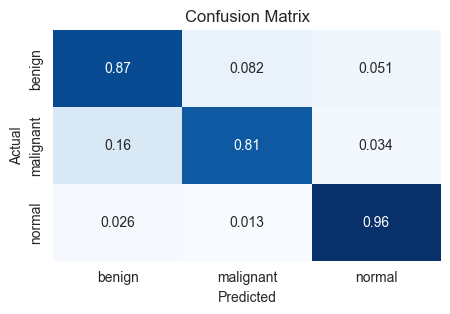

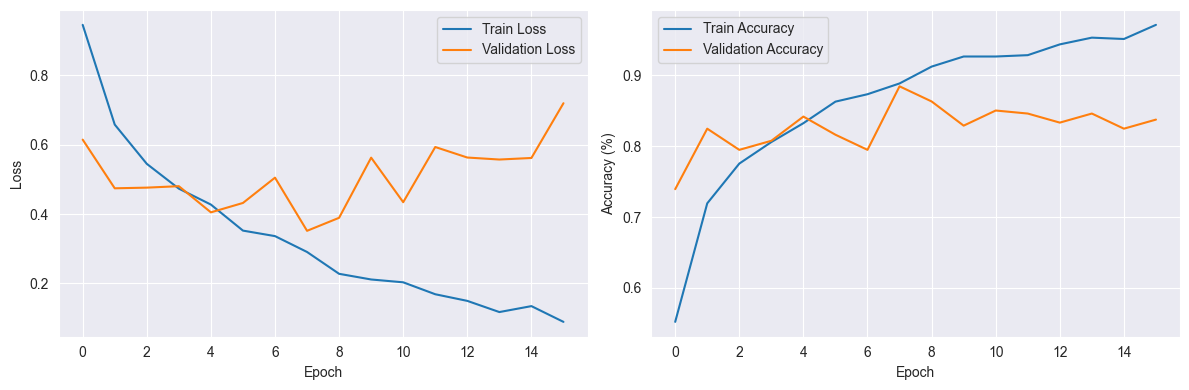

In [200]:
model_fineTuning = train_model_with_early_stopping(
    model, Loss_Function, optimizer, scheduler,
    dataloaders, dataset_sizes, class_names, DEVICE, num_epochs=50, patience=8
)
torch.save(model_fineTuning, os.path.join(split_data_path,"ViT_swin.pth"))

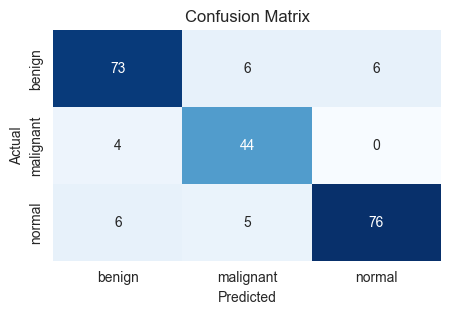

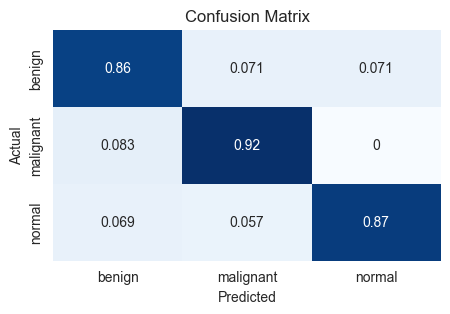

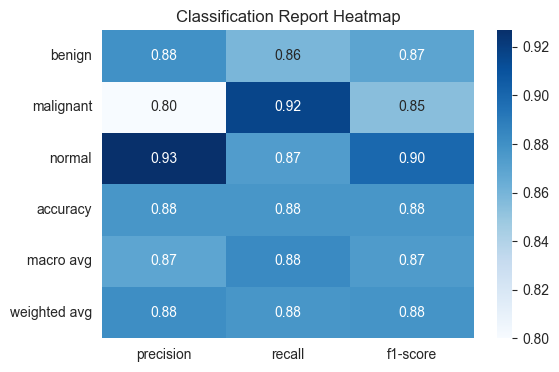

Simplified Classification Report:
             benign  malignant    normal  accuracy  macro avg  weighted avg
precision  0.879518   0.800000  0.926829  0.877273   0.868782      0.880878
recall     0.858824   0.916667  0.873563  0.877273   0.883018      0.877273
f1-score   0.869048   0.854369  0.899408  0.877273   0.874275      0.877851


In [201]:
# Define label names
label_names = [str(class_names[i]) for i in range(len(class_names))]

# Calculate classification report and confusion matrix on unseen test data
y_true = []
y_pred = []

model_fineTuning.eval()  # Set model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model_fineTuning(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate classification report
classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

# Generate confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)
confusion_mat_precent = confusion_matrix(y_true, y_pred, normalize='true')

# Plot the confusion matrix with label names
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the confusion matrix with label names
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat_precent, annot=True, cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Convert the classification report to a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')  # Simplify classification report
plt.title('Classification Report Heatmap')
plt.show()

# Print the simplified classification report
print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])  # Display without support and avg/total rows


Found 27 misclassified images, displaying 15


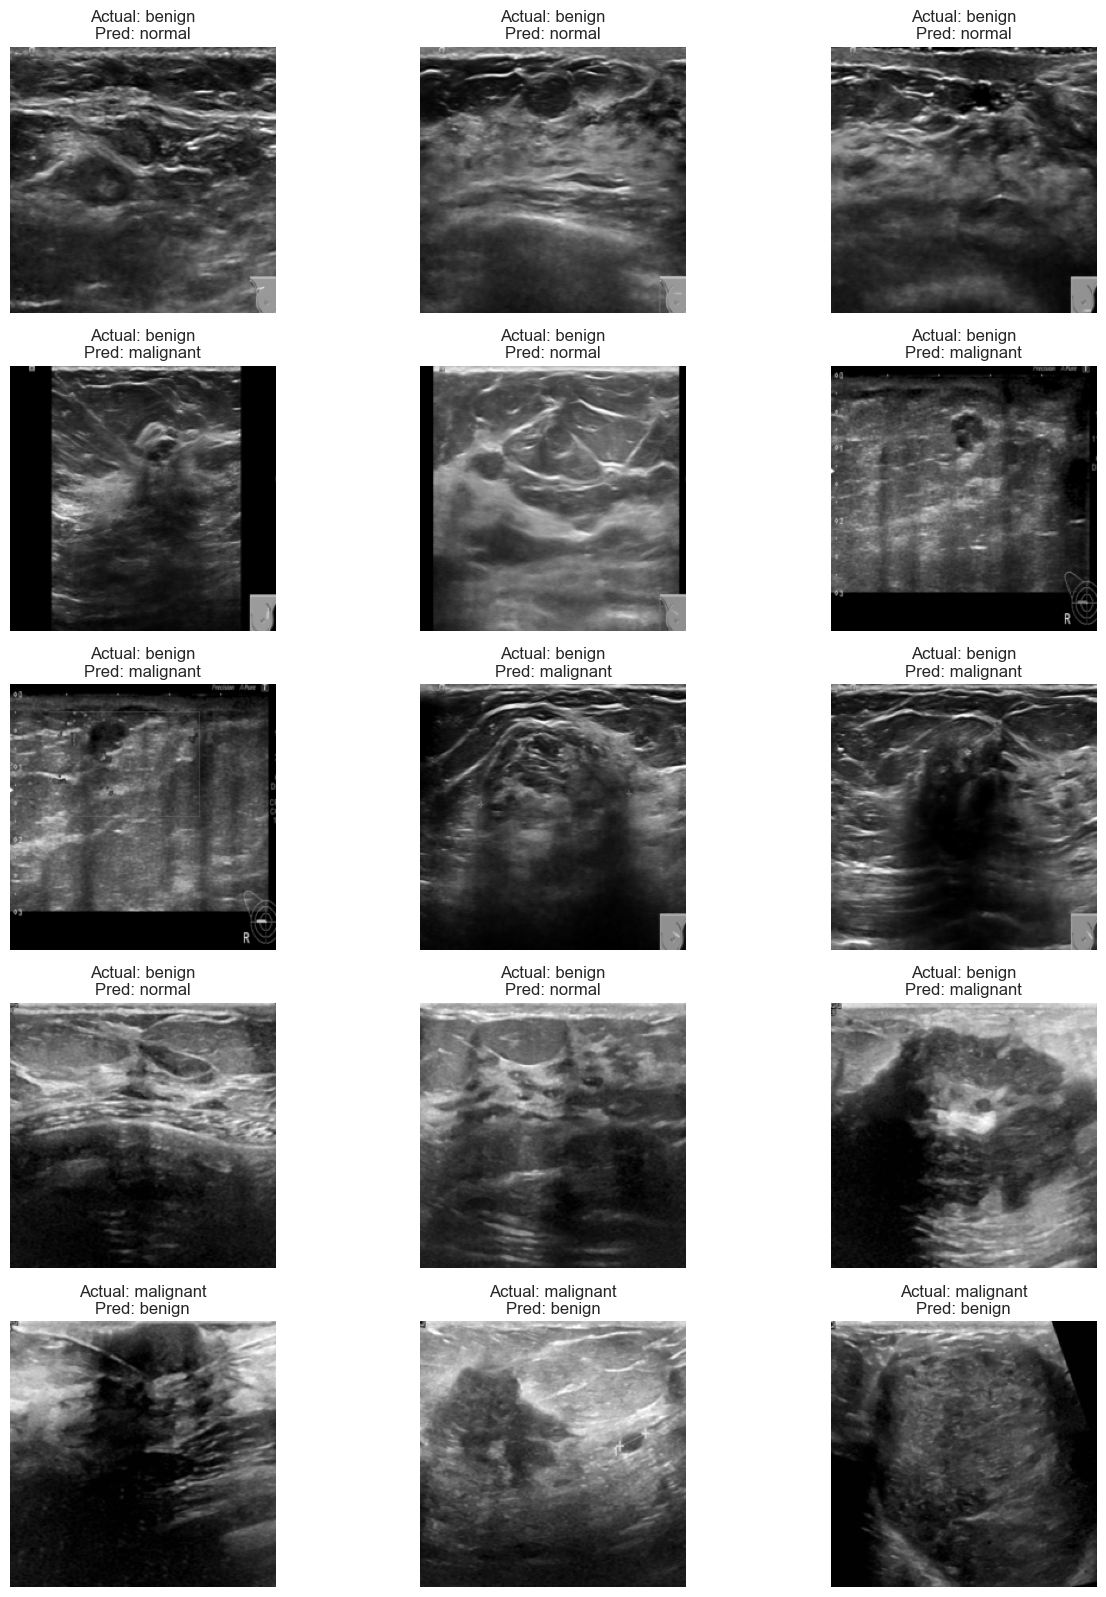

In [204]:
# Collect and display 15 misclassified test images

num_images_to_display=15
mis_images=[]
mis_labels=[]
mis_preds=[]

test_dataloader=DataLoader(
    image_datasets['test'],
    batch_size=32,
    shuffle=False,
    num_workers=4
)

model_fineTuning.eval()

# Loop through the entire test set
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs=inputs.to(DEVICE)
        outputs=model_fineTuning(inputs)
        _, preds=torch.max(outputs,1)

        # Compare labels and predictions
        mismatch=(preds.cpu()!=labels)

        # Save misclassified items
        for i in torch.where(mismatch)[0]:
            img=inputs[i].cpu().numpy().mean(axis=0)  # grayscale
            mis_images.append(img)
            mis_labels.append(labels[i].item())
            mis_preds.append(preds[i].item())

# Limit to the first 15
n=min(num_images_to_display, len(mis_images))
print(f"Found {len(mis_images)} misclassified images, displaying {n}")

# Plot
plt.figure(figsize=(15,20))
for idx in range(n):
    ax=plt.subplot(5,3,idx+1)
    ax.axis('off')
    ax.set_title(f"Actual: {class_names[mis_labels[idx]]}\nPred: {class_names[mis_preds[idx]]}")
    plt.imshow(mis_images[idx], cmap='gray')

plt.show()
